# **MMA PREDICTOR WORKFLOW**
##### By Patrick Kong

[Website](pkong97.github.io) | [Github](https://github.com/pkong97) | [LinkedIn](https://www.linkedin.com/in/patrick-kong-728203247/)

### Contents
This notebook shows the workflow my **MMA Predictor** project.

Introduction
* Background/questions
* Objectives

Data
* Collection
* Cleaning/processing

Analysis
* Correlation matrix
* Correlation heatmap

Prediction Testing
* Training models
* Logistic regression
* Decision tree
* Random forest classification

Conclusion and Next Steps

### **Introduction**

##### Background
Mixed Martial Arts is a unique sport. There exists a large number of variables from stemming from the multitude of styles and attacks allowed in the sport which can make the fights quite unpredictable. Therefore, I sought to create a predictor that could make sense of the sport's chaos and answer the following questions:

* What variables are the most important in determining the winner? (ie. striking? takedowns?)
* Is there a metric that can be used to determine who is the better fighter?

##### Objectives
The objective of this project is to create a model that:
* Predicts better than 50% accuracy
* Create a ranking system for fighters

### **Data**

##### Collection
The data was gathered from [UFC Stats](https://www.ufcstats.com/) using webscrapers built with Python's Beautiful Soup library. Two separate types of data were collected: fighter data and fight data. Both types of data were stored in separate Pandas data frames. The webscraper scripts can be found at the [webscraper section](https://github.com/pkong97/mma-predictor/tree/master/webscrapers) of my github repository. 

**Preview of raw fighter data**

Description of columns:
* id - fighter id
* name - fighter's name
* height - fighter's height (ft, in)
* weight - fighter's weight (lbs)
* reach - fighter's reach (in)
* dob - fighter's date of birth
* ss_min - significant strikes per minute
* str_acc - striking accuracy
* str_a_min - significant strikes absorbed per minute
* str_def - striking defense
* td_avg - takedowns landed average
* td_acc - takedown accuracy (%)
* td_def - takedown defense (%)
* sub_avg - submissions attempted avergae
* wins
* losses
* wl_diff
* momentum - current win/loss streak

In [13]:
import pandas as pd

fighter_data_raw = pd.read_csv('raw-data/2022-08-25-fighter-data-raw.csv')
fighter_data_raw.head(5)

,id,name,height,weight,reach,dob,ss_min,str_acc,str_a_min,str_def,td_avg,td_acc,td_def,sub_avg,wins,losses,wl_diff,momentum
0,8738eacd62e82a32,Matt Andersen,"6'2""",230.0,NaN,1971,0.00,0,0.00,0,.0.00,0,0,..0.0,0,1,-1,-1
1,9199e0735b83dd32,Andy Anderson,"5'6""",240.0,NaN,1974,0.00,0,0.00,0,.0.00,0,0,..0.0,0,1,-1,-1
2,cf946e03ba2e7666,Kevin Aguilar,"5'7""",155.0,73.0,1988,3.96,40,4.81,52,.0.16,16,78,..0.0,3,4,-1,-4
3,26387c19f32dda0f,Javy Ayala,"6'1""",265.0,NaN,1988,0.83,25,5.00,33,.0.00,0,0,..0.0,0,0,0,0
4,d6a3e131ad4ba064,Angga,"5'7""",145.0,68.0,1989,3.56,38,3.77,53,.0.00,0,33,..0.0,0,1,-1,-1


**Preview of raw fight data**

Description of columns:
* event_id
* event_name
* f1_id - id of fighter 1
* f1_name - name of fighter 1
* f2_id - id of fighter 2
* f2_name - name of fighter 2
* winner_id - id of winner

In [11]:
fight_data_raw = pd.read_csv('raw-data/2022-08-25-fight-data-raw.csv')
fight_data_raw.head(5)

,event_id,event_name,f1_id,f1_name,f2_id,f2_name,winner_id
0,4f853e98886283cf,UFC 278: Usman vs. Edwards,f1fac969a1d70b08,Leon Edwards,f1b2aa7853d1ed6e,Kamaru Usman,f1fac969a1d70b08
1,4f853e98886283cf,UFC 278: Usman vs. Edwards,2e5c2aa8e4ab9d82,Paulo Costa,00e11b5c8b7bfeeb,Luke Rockhold,2e5c2aa8e4ab9d82
2,4f853e98886283cf,UFC 278: Usman vs. Edwards,c03520b5c88ed6b4,Merab Dvalishvili,d0f3959b4a9747e6,Jose Aldo,c03520b5c88ed6b4
3,4f853e98886283cf,UFC 278: Usman vs. Edwards,3cf66c62d9069f43,Lucie Pudilova,fdbefee0827e1567,Wu Yanan,3cf66c62d9069f43
4,4f853e98886283cf,UFC 278: Usman vs. Edwards,49e96ff8ab781589,Tyson Pedro,f703250471acaf96,Harry Hunsucker,49e96ff8ab781589


##### Cleaning/processing

The follow steps were taken to clean the datasets:
* Fighter data
    * All rows with missing height and weight were dropped
    * Missing reach values were replaced with the mean reach of the weight class
    * Heights were changed into inches
    * Outliers were removed from the columns 'ss_min', 'str_acc', 'str_a_min', 'str_def'  
* Fight data
    * This data was aggregated with the cleaned fighter data to create a composite database that contains the every fighter, their fights, and their attributes
* Aggregated dataset
    * Each row consists of a fight instance that shows a fighter, their opponent, the differences between their attributes, and the outcome of the fight
    * The columns 'elo' and 'elo_opp' were added to create an elo rating for each fighter, similar to that of chess

The data cleaning scripts can be found at the [data cleaning section](https://github.com/pkong97/mma-predictor/tree/master/data-cleaning) of my github respository.

**Elo ranking formula**

Formula for expected score of player A:

${\displaystyle E_{\mathsf {A}}={\frac {1}{1+10^{(R_{\mathsf {B}}-R_{\mathsf {A}})/400}}}~}$

A fighter's expected score is their probability of winning. Therefore, the higher elo a figher has, the higher their probability of winning.

Formula for updating elo:

${\displaystyle R_{\mathsf {A}}'=R_{\mathsf {A}}+60(E_{\mathsf {A}}={\frac {1}{1+10^{(R_{\mathsf {B}}-R_{\mathsf {A}})/400}}})~}$

**Preview of aggregated dataset**

The features of the aggregated data are as follows:
* id - id of fighter
* name - name of fighter
* id_opp - id of opponent
* name_opp - name of opponent
* event_id - event id
* event_name - event name
* elo - elo of fighter
* elo_opp - elo of opponent
* height_diff - difference between fighter and opponent's height
* reach_diff - difference between fighter and opponent's reach
* ss_min_diff - significant strikes per minute differential
* str_acc_diff - striking accuracy differential
* str_a_min_diff - significant strikes absorbed per minute differential
* str_def_diff - significant strike defense differential
* td_avg_diff - takedown average differential
* td_acc_diff - takedown accuracy differential
* tdd_def_diff - takedown defense differential
* sub_avg_diff - submission average differential
* wins_diff - difference in wins between fighter and opponent
* losses_diff - difference in losses between fighter and opponent
* momentum_diff - difference in win streak between fighter and opponent
* wl_diff_diff - difference in win-loss differentials
* outcome - outcome of the fight

In [22]:
all_fights_fighters_df = pd.read_csv('data/2022-08-25-all-fights-fighters-data.csv')
all_fights_fighters_df.sort_values(by=['Unnamed: 0'], ascending=False).head(6)


,Unnamed: 0,id,name,id_opp,name_opp,event_id,event_name,elo,elo_opp,height_diff,...,str_def_diff,td_avg_diff,td_acc_diff,td_def_diff,sub_avg_diff,wins_diff,losses_diff,momentum_diff,wl_diff_diff,outcome
13085,13085,00e11b5c8b7bfeeb,Luke Rockhold,2e5c2aa8e4ab9d82,Paulo Costa,4f853e98886283cf,UFC 278: Usman vs. Edwards,1109.535998,1103.120353,2.0,...,6.0,0.17,-46.0,-14.0,1.0,9.0,3.0,-4.0,6.0,L
13084,13084,2e5c2aa8e4ab9d82,Paulo Costa,00e11b5c8b7bfeeb,Luke Rockhold,4f853e98886283cf,UFC 278: Usman vs. Edwards,1103.120353,1109.535998,-2.0,...,-6.0,-0.17,46.0,14.0,-1.0,-9.0,-3.0,4.0,-6.0,W
13083,13083,d0f3959b4a9747e6,Jose Aldo,c03520b5c88ed6b4,Merab Dvalishvili,4f853e98886283cf,UFC 278: Usman vs. Edwards,1216.774682,1159.868563,1.0,...,2.0,-6.05,14.0,13.0,-0.2,13.0,5.0,-9.0,8.0,L
13082,13082,c03520b5c88ed6b4,Merab Dvalishvili,d0f3959b4a9747e6,Jose Aldo,4f853e98886283cf,UFC 278: Usman vs. Edwards,1159.868563,1216.774682,-1.0,...,-2.0,6.05,-14.0,-13.0,0.2,-13.0,-5.0,9.0,-8.0,W
13081,13081,fdbefee0827e1567,Wu Yanan,3cf66c62d9069f43,Lucie Pudilova,4f853e98886283cf,UFC 278: Usman vs. Edwards,917.791968,915.752514,0.0,...,-3.0,0.19,3.0,2.0,-0.5,-2.0,0.0,-5.0,-2.0,L
13080,13080,3cf66c62d9069f43,Lucie Pudilova,fdbefee0827e1567,Wu Yanan,4f853e98886283cf,UFC 278: Usman vs. Edwards,915.752514,917.791968,0.0,...,3.0,-0.19,-3.0,-2.0,0.5,2.0,0.0,5.0,2.0,W


##### Analysis

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
all_fights_fighters_df.describe()

,Unnamed: 0,elo,elo_opp,height_diff,reach_diff,ss_min_diff,str_acc_diff,str_a_min_diff,str_def_diff,td_avg_diff,td_acc_diff,td_def_diff,sub_avg_diff,wins_diff,losses_diff,momentum_diff,wl_diff_diff
count,13086.000000,13086.000000,13086.000000,13086.000000,13086.000000,13086.000000,13086.000000,13086.000000,13086.000000,13086.000000,13086.000000,13086.000000,13086.000000,13086.000000,13086.000000,13086.000000,13086.000000
mean,6542.500000,1040.896990,1040.896990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
std,3777.747146,67.405262,67.405262,2.539832,3.470319,1.562746,10.700523,1.568358,10.287499,1.793417,28.082514,29.508751,1.022474,7.151091,4.275102,3.350816,5.716938
min,0.000000,853.961053,853.961053,-13.000000,-13.750000,-8.990000,-56.000000,-14.180000,-56.000000,-11.770000,-100.000000,-100.000000,-11.900000,-29.000000,-18.000000,-20.000000,-24.000000
25%,3271.250000,1000.000000,1000.000000,-2.000000,-2.000000,-1.010000,-7.000000,-0.910000,-6.000000,-1.050000,-16.000000,-18.000000,-0.500000,-4.000000,-2.000000,-2.000000,-3.000000
50%,6542.500000,1027.730742,1027.730742,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9813.750000,1075.647304,1075.647304,2.000000,2.000000,1.010000,7.000000,0.910000,6.000000,1.050000,16.000000,18.000000,0.500000,4.000000,2.000000,2.000000,3.000000
max,13085.000000,1388.911657,1388.911657,13.000000,13.750000,8.990000,56.000000,14.180000,56.000000,11.770000,100.000000,100.000000,11.900000,29.000000,18.000000,20.000000,24.000000


**Correlation Matrix**

* We can see that the predictors are not very correlated with each other, meaning a low possibility of multicollinearity
* str_min_diff, str_acc_diff seem to have higher positive correlations with momentum

In [57]:
# Drop non-numeric columns
corr = all_fights_fighters_df.drop(all_fights_fighters_df[all_fights_fighters_df.outcome == "L"].index)
corr = corr.drop(['Unnamed: 0', 'id', 'name', 'id_opp', 'name_opp', 'event_id', 'event_name', 'outcome'], axis = 1)
corr = corr.corr()
corr

,elo,elo_opp,height_diff,reach_diff,ss_min_diff,str_acc_diff,str_a_min_diff,str_def_diff,td_avg_diff,td_acc_diff,td_def_diff,sub_avg_diff,wins_diff,losses_diff,momentum_diff,wl_diff_diff
elo,1.000000,0.620511,0.011821,0.100809,-0.027085,0.004674,-0.009452,0.000280,0.023665,-0.006040,-0.030251,-0.009478,0.092822,-0.107715,0.076475,0.213202
elo_opp,0.620511,1.000000,-0.005508,0.080546,-0.067712,-0.049532,0.123864,-0.120745,-0.054313,-0.074618,-0.084330,-0.050591,-0.240371,-0.160667,0.020193,-0.176775
height_diff,0.011821,-0.005508,1.000000,0.545316,0.103162,0.046144,-0.039423,-0.080871,-0.140536,0.015124,-0.013572,0.108591,0.013255,-0.034068,-0.001525,0.046400
reach_diff,0.100809,0.080546,0.545316,1.000000,0.001207,-0.015376,-0.025878,-0.131529,-0.089269,0.011795,-0.059239,0.066306,-0.020701,-0.115565,0.057026,0.071631
ss_min_diff,-0.027085,-0.067712,0.103162,0.001207,1.000000,0.304210,0.233333,0.233051,-0.156098,0.077116,0.275435,-0.163988,0.146005,0.016668,0.117234,0.176468
str_acc_diff,0.004674,-0.049532,0.046144,-0.015376,0.304210,1.000000,-0.213667,0.077398,0.141629,0.178061,0.075265,0.075007,0.102509,-0.058535,0.159388,0.183864
str_a_min_diff,-0.009452,0.123864,-0.039423,-0.025878,0.233333,-0.213667,1.000000,-0.344828,-0.257949,-0.196519,-0.015361,-0.086586,-0.128772,0.046292,-0.144337,-0.207714
str_def_diff,0.000280,-0.120745,-0.080871,-0.131529,0.233051,0.077398,-0.344828,1.000000,0.029987,0.127596,0.247280,-0.141760,0.179833,0.043367,0.113975,0.197855
td_avg_diff,0.023665,-0.054313,-0.140536,-0.089269,-0.156098,0.141629,-0.257949,0.029987,1.000000,0.364267,0.034195,0.146070,0.023459,-0.088412,0.121800,0.106125
td_acc_diff,-0.006040,-0.074618,0.015124,0.011795,0.077116,0.178061,-0.196519,0.127596,0.364267,1.000000,0.235979,0.021930,0.105539,0.037421,0.010026,0.105896


**Correlation Heatmap**

<AxesSubplot:>

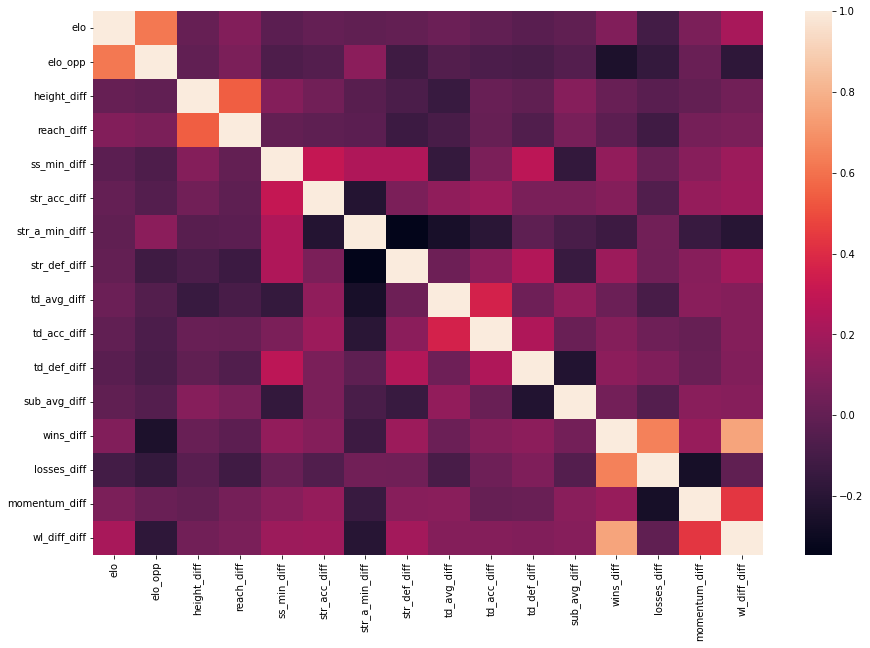

In [55]:
# Create correlation heatmap
plt.figure(figsize = (15,10))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

##### Prediction Testing

Using scikitlearn, we train and test a logistic regression, decision tree, and random forest classifier model.

In [58]:
# load training dataset
train = pd.read_csv('data/composite-train.csv')

#Import models from scikit learn module:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold   #For K-fold cross validation
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

#Generic function for making a classification model and accessing performance:
def classification_model(model, data, predictors, outcome):
    #Fit the model:
    model.fit(data[predictors],data[outcome])
  
    #Make predictions on training set:
    predictions = model.predict(data[predictors])
  
    #Print accuracy
    accuracy = metrics.accuracy_score(predictions,data[outcome])
    print("Accuracy : %s" % "{0:.3%}".format(accuracy))

    #Perform k-fold cross-validation with 10 folds
    kf = KFold(n_splits=10, shuffle=False)
    error = []
    for train, test in kf.split(data):
        # Filter training data
        train_predictors = (data[predictors].iloc[train,:])
    
        # The target we're using to train the algorithm.
        train_target = data[outcome].iloc[train]
    
        # Training the algorithm using the predictors and target.
        model.fit(train_predictors, train_target)
    
        #Record error from each cross-validation run
        error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
 
    print ("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

    #Fit the model again so that it can be refered outside the function:
    model.fit(data[predictors],data[outcome]) 

**Training models**

In [78]:
# Assign prediction variables
predictors = ['elo','elo_opp','height_diff','reach_diff','ss_min_diff','str_acc_diff', 
            'str_a_min_diff','str_def_diff','td_avg_diff','td_acc_diff','td_def_diff','sub_avg_diff', 
            'wins_diff','losses_diff','momentum_diff','wl_diff_diff']
outcome = 'outcome'

# Fit logistic regression model
model_lr = LogisticRegression(max_iter=1000)
classification_model(model_lr, train, predictors, outcome)

Accuracy : 75.706%
Cross-Validation Score : 75.217%


In [69]:
# Fit decision tree classifier model
model_dtc = DecisionTreeClassifier()
classification_model(model_dtc, train, predictors, outcome)

Accuracy : 100.000%
Cross-Validation Score : 67.815%


In [70]:
# Fit random forest classifier model
model_rfc = RandomForestClassifier(n_estimators=30)
classification_model(model_rfc, train, predictors, outcome)

Accuracy : 99.900%
Cross-Validation Score : 76.428%


Here we load a test dataset with the outcome column removed.

In [71]:
test = pd.read_csv('data/composite-test.csv')
results = pd.read_csv('data/test-results.csv')
test = test.iloc[::2]
test = test.reset_index()
results = results.iloc[::2]
results = results.reset_index()

**Logistic regression**

Running our test dataset through a logisitic regression models gives a prediction rate of 89.93%.


In [80]:
# Logistic Regression Testing
model_lr = LogisticRegression(max_iter = 1000)
model_lr.fit(train[predictors],train[outcome])
test[outcome] = model_lr.predict(test[predictors])

score = 0
total = len(results)
for i in range(0, total):
    if results.loc[i, 'outcome'] == test.loc[i, 'outcome']:
        score += 1
print('Prediction accuracy is ' + str(round((score*100/total),2)) + '%')

Prediction accuracy is 89.93%


**Decision tree**

Running our test dataset through a decision tree model gives a prediction rate of 73.83%.

In [81]:
# Decision Tree Testing
model_dtc = DecisionTreeClassifier()
model_dtc.fit(train[predictors],train[outcome])
predictions = model_dtc.predict(train[predictors])
test[outcome] = model_dtc.predict(test[predictors])

score = 0
total = len(results)
for i in range(0, total):
    if results.loc[i, 'outcome'] == test.loc[i, 'outcome']:
        score += 1
print('Prediction accuracy is ' + str(round((score*100/total),2)) + '%')

Prediction accuracy is 73.83%


**Random forest classification**

Running our test dataset through a decision tree model gives a prediction rate of 85.91%.

In [79]:
# Random Forest Testing
model_rfc = RandomForestClassifier()
model_rfc.fit(train[predictors],train[outcome])
predictions = model_rfc.predict(train[predictors])
test[outcome] = model_rfc.predict(test[predictors])

score = 0
total = len(results)
for i in range(0, total):
    if results.loc[i, 'outcome'] == test.loc[i, 'outcome']:
        score += 1
print('Prediction accuracy is ' + str(round((score*100/total),2)) + '%')

Prediction accuracy is 85.91%


##### Conclusion and Next Steps

Summary of results:

Logistic regression
* 75.71% prediction accuracy on training set
* 75.21% cross-validation score
* 89.93% prediction accuracy

Decision tree
* 100.0% prediction accuracy on training set
* 67.82% cross-validation score
* 73.83% prediction accuracy

Random forest classification
* 99.90% prediction accuracy on training set
* 76.43% cross-validation score
* 85.91% prediction accuracy

Based on the results, the logistic regression model has the overall greatest prediction accuracy at **89.93%**, with the random forest classification model close behind at **85.91%**. These prediction rates meet our initial objective of predicting better than 50% accuracy. 

As for next steps, we can improve feature engineering through greater analysis of decision variables, and create an interactive dashboard to display real-time predictions.
